In [33]:
import warnings
warnings.filterwarnings('ignore')

- 수동으로 적합한 차수를 찾아 ARIMA모형을 학습
- ARIMA모형보다 더 '일평균기온' 데이터의 특성(계절성)을 반영해주는 SARIMA 모형을 구현
- auto-arima모형으로 적합한 모델을 찾아 구현해보고 세 모델의 성능을 비교

# 2. 모델1.ARIMA
### 2.1 데이터 로드 및 시각화

In [34]:
import pandas as pd
file_path = './ta_20240920220735.csv'

# CSV 파일을 8행부터 읽어오기 (skiprows=7)
df = pd.read_csv(file_path, skiprows=6,
                 encoding='CP949',
                 index_col=0, #날짜열을 인덱스로 지정해야합니다!
                 parse_dates=True
                 )
df.index.name = None #인덱스명 제거
df.head(3)

,지점,평균기온(℃),최저기온(℃),최고기온(℃)
2000-01-01,108,5.5,1.8,9.9
2000-01-02,108,4.2,-0.9,6.9
2000-01-03,108,-2.2,-4.6,0.1


In [35]:
ts = df.iloc[-1825:, 1] #'평균기온' 컬럼만 선택, 최근 약 5년치 데이터만 선택
ts.head(3)

2019-09-22    18.6
2019-09-23    20.0
2019-09-24    19.8
Name: 평균기온(℃), dtype: float64

<Axes: >

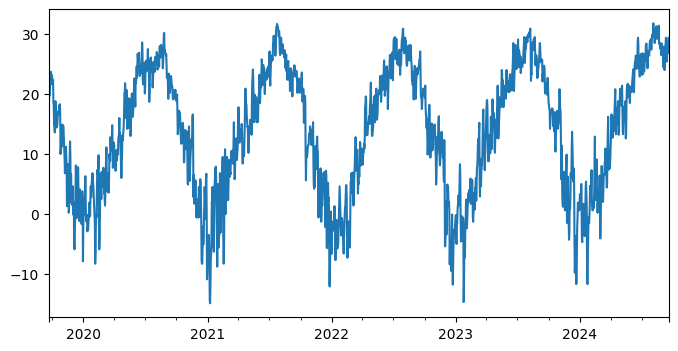

In [36]:
# 날짜 주기(frequency)를 명시적으로 지정해 경고를 제거
ts.index = pd.to_datetime(ts.index, format='%Y-%m-%d')
ts = ts.asfreq('D')  # 일별 데이터로 주기 설정
ts.plot(figsize=(8,4)) #시각화

### 2.2 정상성 여부 검사 (ADF 검정)



In [37]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import kpss

def get_test(df):
# 정상성 검사를 위한 ADF Test 실행
    adf_test = sm.tsa.adfuller(df)
    print(f'ADF Statistic:{adf_test[0]:.3f}')
    print(f'p-value:{adf_test[1]:.3f}')

    kpss_test = kpss(ts, regression='ct')  # 'c'는 상수 포함, 'ct'는 상수 및 추세 포함
    print(f'KPSS Statistic:{kpss_test[0]:.3f}')
    print(f'p-value:{kpss_test[1]:.3f}')
get_test(ts)

ADF Statistic:-1.762
p-value:0.400
KPSS Statistic:0.090
p-value:0.100


p값이 유의수준(0.05)보다 크기 때문에 최근 서울시 평균기온 데이터가 '정상성'을 만족하지 못함(H0)을 알 수 있다.

p값이 유의수준(0.05)보다 크기 때문에 '정상성'을 만족(H0)

### 정상성 검정 결과

- ADF 검정 결과
```
ADF 테스트는 귀무 가설이 "데이터가 비정상성이다"라고 가정합니다.
여기서 p-value가 0.05보다 크기 때문에, 귀무 가설인 "데이터가 비정상성"인 것을 알 수 있습니다.
```

- KPSS 검정 결과
```
KPSS 테스트는 귀무 가설이 "데이터가 정상성이다"라고 가정합니다.
p-value가 0.1이므로 귀무 가설인 정상성 데이터라고 확인할 수 있습니다.
```

하지만 ADF검정에서 데이터가 정상성을 띠지 않음을 확인했으므로 차분을 해봅시다~!

### 2.3 차분

차분(바로 이전 시점과의 차이를 계산!)은 시계열 데이터의 **트렌드(추세)**를 제거하고, 데이터를 정상성 상태로 만들어 시계열 모델을 잘 적합시킬 수 있습니다.

KPSS검정결과는 정상성을 만족하지만, ADF검정결과 비정상성을 가지므로 차분해봅시다.

2019-09-23    1.4
2019-09-24   -0.2
2019-09-25    1.1
Freq: D, Name: 평균기온(℃), dtype: float64

<Axes: >

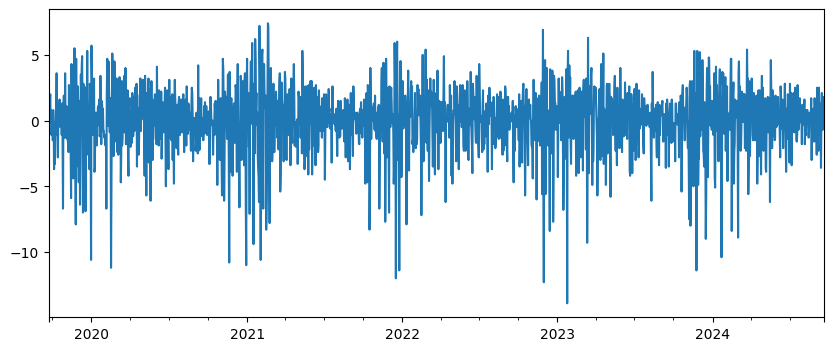

In [38]:
diff_data = ts.diff().dropna() #dropna(): 차분하면 NaN값이 생기므로 제거해줍니다.
display(diff_data.head(3))
diff_data.plot(figsize=(10,4))

차분후 두 검정(ADF, KPSS)에서 모두 '정상성을 만족'합니다.

In [39]:
get_test(diff_data)

ADF Statistic:-13.502
p-value:0.000
KPSS Statistic:0.090
p-value:0.100


### 2.4 훈련,평가데이터 분할

In [40]:
# 전체 데이터의 길이 확인
total_len = len(diff_data)

# 80:20 비율로 훈련/평가 데이터 분할
train_size_n = int(total_len * 0.8)
train_data = diff_data[:train_size_n]
test_data = diff_data[train_size_n:]

print(total_len, len(train_data), len(test_data))

1824 1459 365


In [41]:
test_data.head(3)

2023-09-21   -0.5
2023-09-22    0.4
2023-09-23    1.3
Freq: D, Name: 평균기온(℃), dtype: float64

### 2.5 ACF/PACF 그래프를 통한 차수 결정

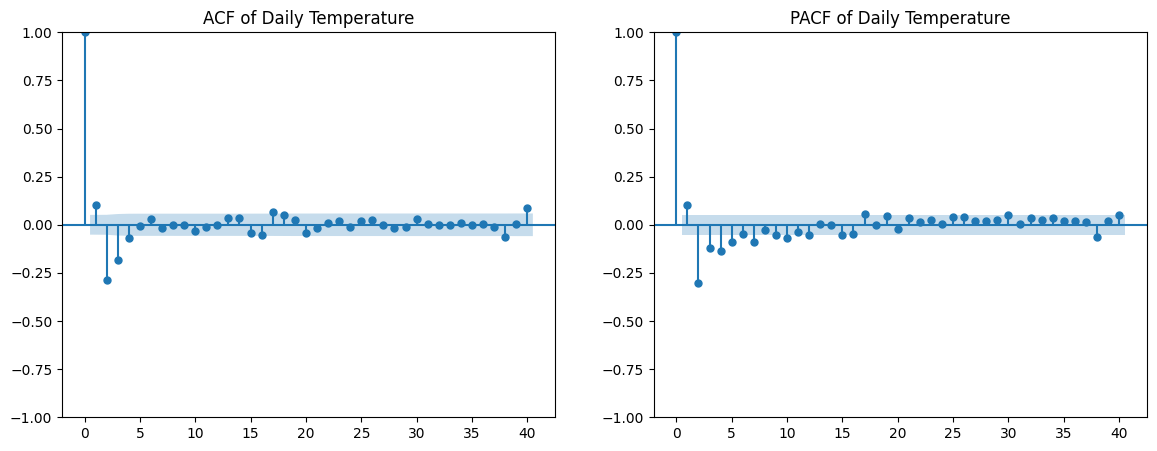

In [42]:
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# ACF와 PACF 플롯을 그려 p,q결정
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ACF plot
plot_acf(train_data, lags=40, ax=axes[0])
axes[0].set_title('ACF of Daily Temperature')

# PACF plot
plot_pacf(train_data, lags=40, ax=axes[1])
axes[1].set_title('PACF of Daily Temperature')

plt.show()

##### ACF, PACF 그래프 해석
- 시차 1: 약 0.12로 양의 상관관계를 가집니다. 그러나 이 값은 미미한 수준입니다.
- 시차 2: 약 -0.3으로 음의 상관관계를 가집니다. 이는 통계적으로 유의미한 상관관계로 볼 수 있습니다.
- 시차 2 이후: ACF가 거의 0에 가까워지며, 신뢰 구간 내에 들어옵니다.
    - 시차 2에서 음의 상관관계가 강하게 나타난 후, 그 이후에는 유의미한 상관관계가 거의 없기 때문에 **이동평균차수인 q와 자기회귀계수 p를 2로 설정**

### 2.6. ARIMA(2,1,2) 모델링

In [43]:
# ARIMA 모델 적합
arima_model = tsa.ARIMA(train_data, order=(2,1,2))
arima_model = arima_model.fit()
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                평균기온(℃)   No. Observations:                 1459
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -3290.680
Date:                Tue, 01 Oct 2024   AIC                           6591.359
Time:                        09:51:12   BIC                           6617.784
Sample:                    09-23-2019   HQIC                          6601.217
                         - 09-20-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8912      0.024     37.221      0.000       0.844       0.938
ar.L2         -0.3033      0.022    -13.774      0.000      -0.346      -0.260
ma.L1         -1.8875      0.016   -117.091      0.000      -1.919      -1.856
ma.L2          0.8921      0.016     55.465      0.000       0.861       0.924
sigma2         5.3228      0.138     38.489      0.000       5.052       5.594
===================================================================================
Ljung-Box (L1) (Q):                   1.44   Jarque-Bera (JB):               551.96
Prob(Q):                              0.23   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -0.78
Prob(H) (two-sided):                  0.11   Kurtosis:                         5.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 2.7. ARIMA 예측

In [44]:
# test 데이터에 대해 예측 수행 (steps는 평가 데이터 크기와 동일)
forecast_object = arima_model.get_forecast(steps=len(test_data), alpha=0.05)  # 95% 신뢰 구간
forecast = forecast_object.predicted_mean
conf_int = forecast_object.conf_int()
forecast

2023-09-21   -0.040207
2023-09-22    0.974924
2023-09-23    0.830164
2023-09-24    0.393241
2023-09-25    0.047767
                ...   
2024-09-15   -0.123453
2024-09-16   -0.123453
2024-09-17   -0.123453
2024-09-18   -0.123453
2024-09-19   -0.123453
Freq: D, Name: predicted_mean, Length: 365, dtype: float64

### 2.8. ARIMA 성능 확인

In [45]:
from sklearn.metrics import mean_squared_error
import numpy as np

def get_metrics(test_data, forecast):
    # MSE (Mean Squared Error) 계산
    mse = mean_squared_error(test_data, forecast)
    print(f'MSE: {mse:.3f}')

    # RMSE (Root Mean Squared Error) 계산
    rmse = np.sqrt(mse)
    print(f'RMSE: {rmse:.3f}')

    # MAPE (Mean Absolute Percentage Error) 계산 (분모가 0인 경우 무시)
    epsilon = 1e-10  # 0으로 나누면 분모에 0이 들어가면서 inf 또는 NaN이 발생할 수 있음.
    #이를 방지하기 위해 작은 값 추가!
    mape = np.mean(np.abs((test_data - forecast) / (test_data + epsilon))) * 100
    print(f'MAPE: {mape:.3f}%')
get_metrics(test_data, forecast)


MSE: 6.001
RMSE: 2.450
MAPE: 2430268701.164%


MAPE가 이렇게 비정상적으로 높은 경우에는 데이터 특성이나 모델의 문제를 확인해야 합니다. 실제 값이 0에 가까운 경우, 이 지표값이 왜곡될 수 있으므로 RMSE,MSE를 함께 고려해야합니다.

RMSE가 2.4이기 때문에 일평균기온 예측에서 2-3도의 오차를 가짐을 알 수 있습니다.

### 2.9. 잔차 자기상관성 확인: Ljung-Box검정

Ljung-Box 테스트는 잔차에 자기 상관이 있는지 확인하는 검정입니다.
잔차가 백색잡음(부작위적)이어야 좋은 모델인데, 잔차에 자기상관이 남아있는지 즉 모델이 모든 패턴을 설명하짐 못하고 예측에 남은 정보가 있는지 확인합니다.


In [46]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Ljung-Box 검정 (잔차의 독립성 검정)
ljung_box_test = acorr_ljungbox(arima_model.resid, lags=[10], return_df=True)
print(ljung_box_test)

      lb_stat  lb_pvalue
10  22.613632   0.012266


현재 Ljung-Box 테스트 결과에서 p-value가 0.05보다 낮습니다. 따라서 모델의 잔차가 무작위가 아니며, **잔차에 "자기상관"이 남아 있다**는 결론을 내릴 수 있습니다.

이는 ARIMA 모델이 계절성을 갖는 데이터(서울시 최근 3년치 일평균기온)를 제대로 설명하지 못하고 있음을 보여줍니다.

### 2.10. 잔차분석

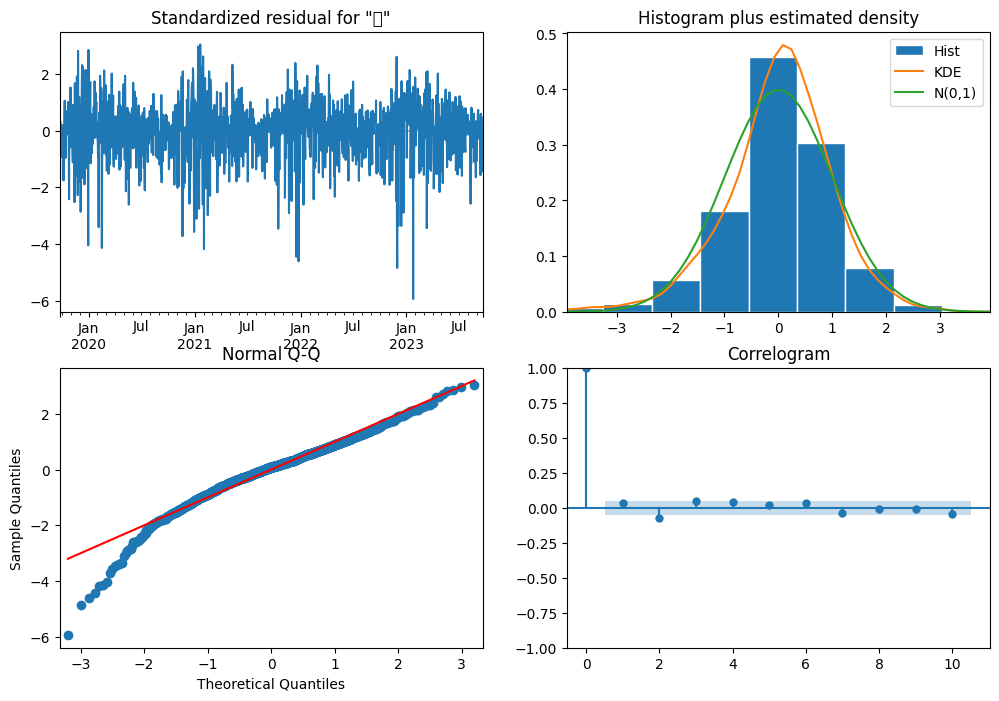

In [47]:
arima_model.plot_diagnostics(figsize=(12, 8))
plt.show()

- Standardized Residuals for T
    - 시간에 따른 모델의 잔차 변동성 시각화
    - **잔차가 일정한 패턴 없이 평균 0을 중심으로 무작위로 분포**해 있다면, 모델이 데이터에 잘 적합된 것입니다.
    - 일부 잔차가 -6에서 2사이 극단 값을 가지는 것을 볼 수 있는데, 모델이 특정 시점의 변동성을 충분히 설명하지 못함을 의미합니다.

- Histogram + Estimated Density
    - 잔차가 정규 분포를 따르는지를 확인하기 위한 히스토그램과 밀도 함수
    - 초록색 선은 N(0,1)정규분포를 나타내고, 주황색 선은 잔차의 추정밀도입니다.
    - 잔차가 이상적으로는 정규 분포를 따라야 합니다만 양 끝단에서 정규분포와 다소차이가 있습니다.
    - 결론적으로 잔차가 완벽하게 정규성을 띄지않지만 대체로 정상성에 가까운 분포를 따릅니다.

- 정규 Q-Q 플롯
    - 잔차가 정규 분포를 따르는지 확인하는 플롯으로, 점들이 빨간색 선에 가까울수록 정규성을 만족함을 보여줍니다.

    - 잔차가 완벽하게 정규성을 따르지 않을 경우, 이는 데이터에 있는 비선형성 또는 특정 시점의 이상치 때문일 수 있습니다. 잔차가 정규성을 띄지 않을 때는 ARIMA 모델이 데이터의 복잡한 패턴을 충분히 설명하지 못하고 있음을 의미합니다. 이 경우 다른 모델을 고려하거나, 잔차의 비정규성 원인을 분석하여 모델을 개선할 수 있습니다.

- Correlogram(잔차의 자기 상관도)
    - 잔차의 자기 상관 관계를 나타냅니다. 잔차에 자기 상관이 없으면 모델이 적절하게 데이터의 패턴을 설명하고 있다고 볼 수 있습니다.

### 2.11. 예측결과 시각화

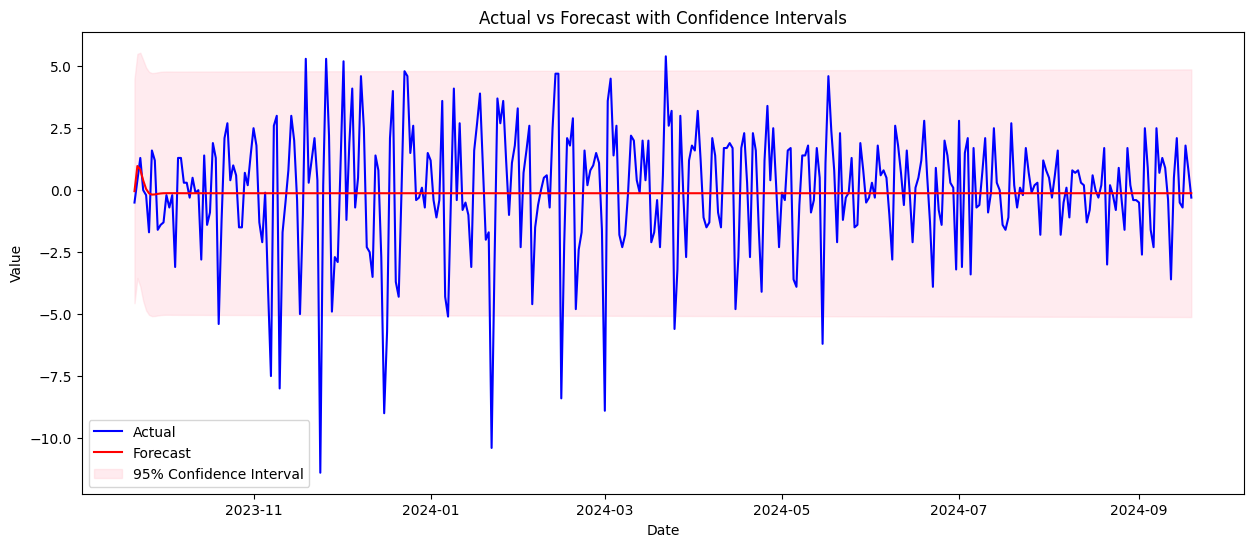

In [48]:
# 시각화

def get_figure(test_data, forecast,conf_int):
    plt.figure(figsize=(15, 6))

    # 실제값
    plt.plot(test_data.index, test_data, label='Actual', color='blue')

    # 예측값
    plt.plot(test_data.index, forecast, label='Forecast', color='red')

    # 신뢰구간
    plt.fill_between(test_data.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3, label='95% Confidence Interval')

    plt.title('Actual vs Forecast with Confidence Intervals')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.show()
get_figure(test_data, forecast,conf_int)

### 2.12. 예측 결과 분석
ARIMA 모델의 예측 결과를 보면 계절성을 반영하지 못한 점이 드러납니다. 이는 ARIMA 모델이 본래 비계절성 데이터에 적합하도록 설계되었기 때문입니다.
기온과 같이 명확한 계절성 패턴을 보이는 데이터에는 ARIMA 모델이 한계가 있습니다.

### 2.13. 신뢰 구간 해석
예측 결과에 표시된 신뢰 구간은 모델이 예측한 값의 불확실성을 나타냅니다.
예측값은 특정 시점에서의 예상 값을 의미하지만, 신뢰 구간은 해당 시점에서 실제 값이 위치할 가능성이 높은 범위를 보여줍니다. 예를 들어, 95% 신뢰 구간은 예측값이 이 구간 내에 있을 확률이 95%임을 의미합니다.

다만 **신뢰 구간이 넓다면, 이는 모델의 예측이 불확실성이 크다는 것을 의미**하며, 신뢰 구간이 좁다면, 모델이 예측한 값이 실제 값이 가까울 가능성이 높습니다. 예측의 신뢰성을 평가할 때, 신뢰 구간의 폭을 함께 고려하는 것이 중요합니다.

### 2.14. **결론**
ARIMA 모델은 비계절성 데이터를 분석하는 데 유용하지만, 기온처럼 뚜렷한 계절적 변동이 있는 데이터에는 적합하지 않습니다.

계절성을 반영하지 못할 경우, 예측의 정확도가 떨어질 수 있습니다.

이를 보완하기 위해, 계절성을 반영할 수 있는 SARIMA 모델을 적용하여 더 나은 예측 성능을 확인해봅시다!

# 3. 모델2. **SARIMA**

- 분석배경

ARIMA 모델은 비계절성 데이터를 다루는 데 유리하지만, 기온과 같은 계절적 특성이 있는 데이터에는 한계가 있습니다. SARIMA 모델을 사용해 계절성을 반영한 예측을 시도해 봅시다.

### 3.1. 계절차분

계절성이 있는 경우에는 계절 차분도 고려해야 합니다. 이는 데이터에서 명확한 주기가 보일 때 사용하는 방법으로, 계절적 비정상성을 제거하는 데 도움을 줍니다.


<Axes: >

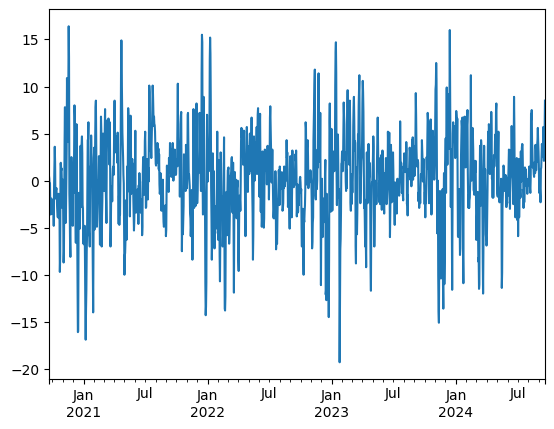

In [49]:
# 계절 차분: 1년(365일) 단위로 차분
seasonal_diff_data = ts.diff(365).dropna()

# 결과 확인
seasonal_diff_data.head(3)

#차분데이터 시각화
display(seasonal_diff_data.plot())

### 3.2. 정상성 확인

계절차분 후 데이터의 정상성 여부를 확인합니다.

In [50]:
get_test(seasonal_diff_data)

ADF Statistic:-14.811
p-value:0.000
KPSS Statistic:0.090
p-value:0.100


두 검정에서 모두 '정상성' 만족 확인

### 3.3. 학습,평가데이터 분할

In [51]:
# 전체 데이터의 길이 확인
total_len = len(seasonal_diff_data)

# 80:20 비율로 훈련/평가 데이터 분할
train_size_n = int(total_len * 0.8)
train_data = seasonal_diff_data[:train_size_n]
test_data = seasonal_diff_data[train_size_n:]

print(total_len, len(train_data), len(test_data))

1460 1168 292


### 3.4. ACF와 PACF 시각화

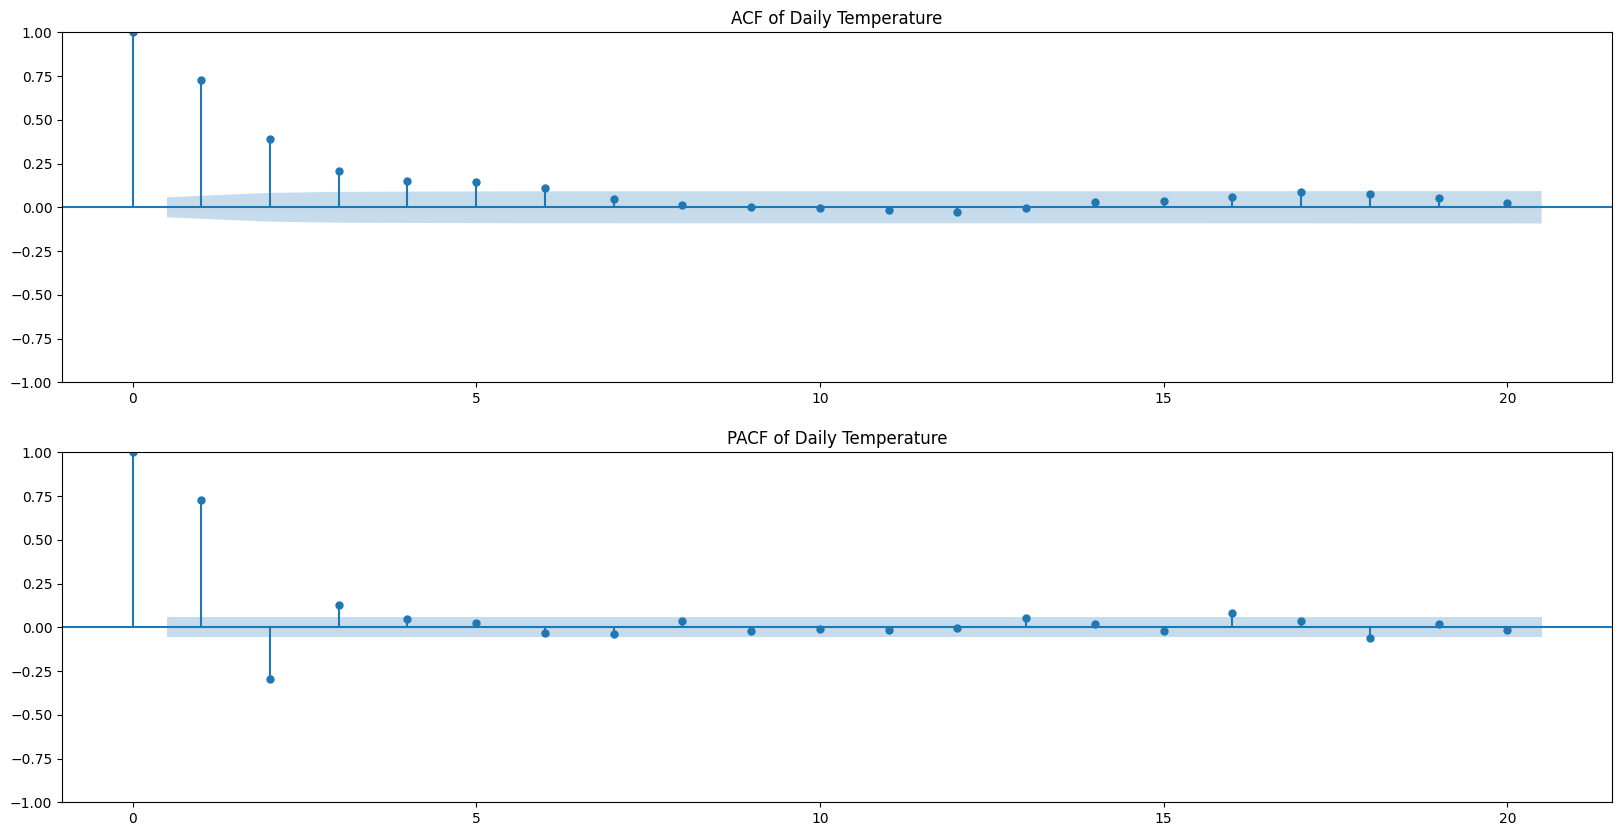

In [52]:
import matplotlib.pyplot as plt

# ACF와 PACF 플롯을 그려 p,q결정
fig, axes = plt.subplots(2, 1, figsize=(20, 10))

# ACF plot
plot_acf(train_data, lags=20, ax=axes[0])
axes[0].set_title('ACF of Daily Temperature')

# PACF plot
plot_pacf(train_data, lags=20, ax=axes[1])
axes[1].set_title('PACF of Daily Temperature')

plt.show()

### ACF, PACF로 계절성 차수 그래프 해석

- ACF 그래프
    - ACF도 시차 1에서 급격히 감소하고 이후 점진적으로 0에 수렴하므로, Q는 2로 시도해볼수있습니다.

- PACF 그래프
    - PACF가 시차 1에서만 유의미하게 나타나고 이후에는 급격히 감소하므로, P=2로 설정하는 것이 적합해 보입니다.

- D(계절적 차분)
    - D=1로 설정하는 것이 일반적입니다.
    - 기온 데이터는 분명한 계절성을 가지고 있기 때문에 1차 계절적 차분을 사용해 계절성을 제거합니다.

### 계절성 차수 결정
    - P, D, Q 값은 계절적 패턴을 모델링하기 위한 계절적 자기회귀(AR), 차분(D), 이동평균(MA) 차수를 의미합니다.
    - 데이터는 일별 기온 데이터이므로 m = 365로 설정하여 1년 주기의 계절성을 반영합니다. m=365는 연간 반복되는 계절성을 반영할 수 있습니다.

### 3.5. 한계
    - 데이터 양: 5년치의 일별 데이터는 약 1800~2000개 이상의 데이터 포인트가 포함되어 있어, 데이터가 많아질수록 계산 시간이 늘어남.
    - 모델 복잡성: SARIMA 모델의 파라미터가 여러 개일수록 (특히 P=1, D=1, Q=1, m=365와 같은 계절성 파라미터가 포함되면), 계산할 것이 많아져서 시간이 더 오래 걸림.
    - SARIMAX의 "X"는 외생 변수(Exogenous variables)를 포함할 수 있다는 의미. 만약 외생 변수를 사용하지 않으면, SARIMA와 동일하게 작동합니다~!

### 3.6. 결론
    - `주간 평균기온으로 대체해 데이터 포인트 수를 줄여서 계산 속도를 올려봅시다.`

# 4. SARIMA w/ 주간데이터

### 4.1 주간 평균기온 집계

주간 데이터로 변환하는 방법은 데이터를 줄여서 계산 시간을 크게 단축할 수 있지만, 변환 이후 모든 과정을 다시 수행해야 합니다. 주간 데이터로 변환한 후, 다시 정상성 검정과 차분을 수행하고, ACF/PACF 분석을 통해 조금 더 모델링에 적합한 차수를 결정해봅시다.

In [53]:
# 주간 데이터로 집계
weekly_data = ts.resample('W').mean()
weekly_data

2019-09-22    18.600000
2019-09-29    21.828571
2019-10-06    21.242857
2019-10-13    16.028571
2019-10-20    15.628571
                ...    
2024-08-25    28.942857
2024-09-01    27.700000
2024-09-08    26.200000
2024-09-15    27.671429
2024-09-22    28.475000
Freq: W-SUN, Name: 평균기온(℃), Length: 262, dtype: float64

### 4.2. 정상성 확인

In [54]:
get_test(weekly_data)

ADF Statistic:-7.509
p-value:0.000
KPSS Statistic:0.090
p-value:0.100


주간데이터는 정상성 시계열임을 확인

<Axes: >

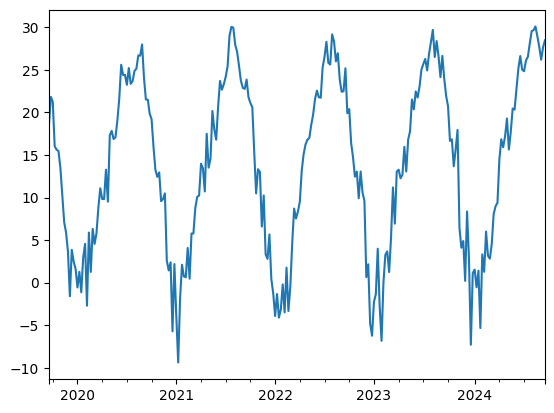

In [55]:
weekly_data.plot()

### 4.3. ACF, PACF로 차수 결정

- 1년(52주)마다 패턴이 있는지 알아보기 위해 lag를 100으로 설정해서 확인해봅시다.

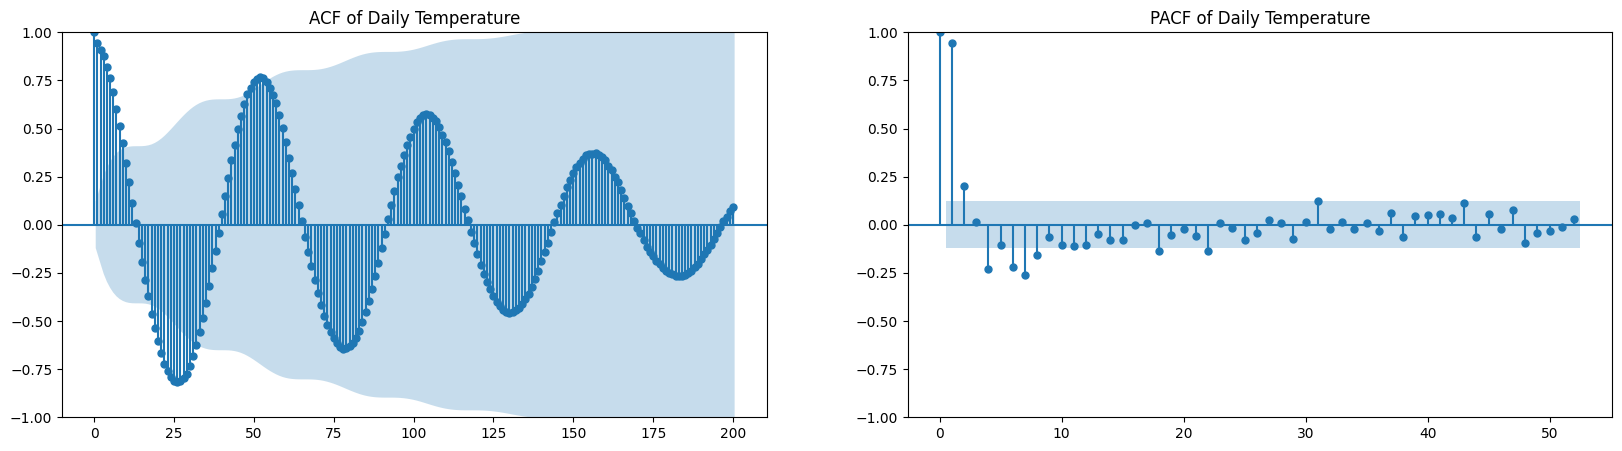

In [56]:
import matplotlib.pyplot as plt

# ACF와 PACF 플롯을 그려 p,q결정
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

# ACF plot
plot_acf(weekly_data, lags=200, ax=axes[0])
axes[0].set_title('ACF of Daily Temperature')

# PACF plot
plot_pacf(weekly_data, lags=52, ax=axes[1])
axes[1].set_title('PACF of Daily Temperature')

plt.show()

- 비계절 차분: 추세(Trend)를 제거하기 위한 차분

    - p(비계절 이동평균 차수): PACF에서는 시차 1에서 매우 높은 상관관계 보임. p=1
    - d(비계절 차분 차수): 정상성 검정 결과 일반 차분은 필요 없으므로 d=0으로 설정. 이미 계절 차분을 진행함.
    - q(비계절 이동 평균 차수): ACF에서 주기적인 변동이 강하므로 비계절적 이동평균이 아님.  q = 0 


- 계절 차분: 계절성을 제거하기 위한 단계
    - P(계절 자기회귀 차수): PACF에서 **52주 주기에 명확한 피크가 없으므로 계절적인 자기 회귀 항(P)은 0**
    - D(계절 차분 차수): 정상성 검정 결과 정상시계열로 판단되었지만, ACF에서 계절적 패턴이 매우 강하므로 계절 차분 시도(실제 성능좋음) D = 1
    - Q(계절 이동평균 차수): ACF에서 52주 주기마다 반복되는 패턴을 보이므로 Q=1
    - m(계절주기): **계절성 주기(m)**는 주간 데이터로 변환했으므로 m=52(52주)로 설정


In [57]:
# 전체 데이터의 길이 확인
total_len = len(weekly_data)

# 80:20 비율로 훈련/평가 데이터 분할
train_size_n = int(total_len * 0.8)
train_data = weekly_data[:train_size_n]
test_data = weekly_data[train_size_n:]

print(total_len, len(train_data), len(test_data))

262 209 53


### 4.4 SARIMA 모델링

SARIMAX의 "X"는 **외생 변수(Exogenous variables)**를 포함할 수 있다는 의미입니다. 만약 외생 변수를 사용하지 않으면, SARIMA와 동일하게 작동합니다.

In [71]:
%%time

from statsmodels.tsa.statespace.sarimax import SARIMAX

# SARIMA 모델 적합
sarima_model = SARIMAX(train_data,
                       order=(1, 0, 0),  # p, d, q
                       seasonal_order=(0, 1, 1, 52))  # P, D, Q, m (주기 52주)
sarima_model = sarima_model.fit()
sarima_model.summary()


CPU times: total: 53 s
Wall time: 14.8 s


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                              평균기온(℃)   No. Observations:                  209
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 52)   Log Likelihood                -385.147
Date:                              Tue, 01 Oct 2024   AIC                            776.294
Time:                                      09:53:54   BIC                            785.463
Sample:                                  09-22-2019   HQIC                           780.018
                                       - 09-17-2023                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1966      0.077      2.554      0.011       0.046       0.347
ma.S.L52      -0.5826      0.152     -3.841      0.000      -0.880      -0.285
sigma2         6.9255      0.933      7.425      0.000       5.097       8.754
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 3.94
Prob(Q):                              0.95   Prob(JB):                         0.14
Heteroskedasticity (H):               0.88   Skew:                            -0.22
Prob(H) (two-sided):                  0.65   Kurtosis:                         3.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 4.5. SARIMA 예측

In [72]:
# 테스트 데이터에 대해 예측 수행
n_periods = len(test_data)
sarima_forecast = sarima_model.get_forecast(steps=n_periods)

# 예측값
forecast_values = sarima_forecast.predicted_mean

# 신뢰 구간
conf_int = sarima_forecast.conf_int()

forecast_values.head(3)

2023-09-24    20.758040
2023-10-01    20.506769
2023-10-08    17.393791
Freq: W-SUN, Name: predicted_mean, dtype: float64

### 4.6. SARIMA 성능 확인

In [73]:
get_metrics(test_data, forecast_values)

MSE: 9.819
RMSE: 3.134
MAPE: 55.107%


### 4.7. 잔차 자기상관성 확인

SARIMA 모델의 잔차 분석을 통해 잔차가 무작위로 분포되어 있는지 확인합니다.

In [74]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Ljung-Box 검정 (잔차의 독립성 검정)
ljung_box_test = acorr_ljungbox(sarima_model.resid, lags=[10], return_df=True)
print(ljung_box_test)

      lb_stat      lb_pvalue
10  890.77116  6.167978e-185


### 4.8 잔차분석

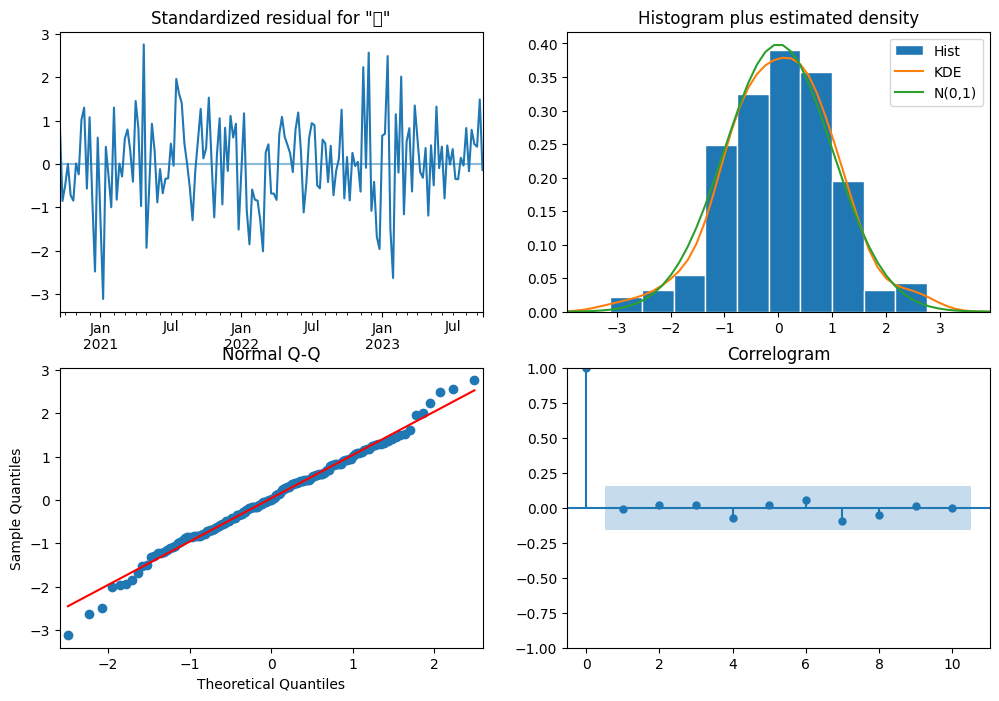

In [62]:
# 모델의 잔차 분석
sarima_model.plot_diagnostics(figsize=(12, 8))
plt.show()

- Standardized Residuals for T(표준화 잔차 분석)
    - 시간에 따른 잔차가 플롯된 그래프입니다. 잔차는 평균 0을 중심으로 랜덤하게 분포되어야 이상적인 모델입니다.
    - 여기서는 일부 구간에서 다소 큰 변동(-3에서 3 사이)이 보이긴 하지만, 대체로 일정한 패턴이 없고 평균 0에 가까운 모습을 보입니다.
    - 즉, 잔차가 크게 비정상적이거나 특정한 패턴을 따르지 않아 모델이 적절히 데이터를 설명하고 있을 가능성이 있습니다.

- Histogram + Estimated Density(히스토그램 및 커널 밀도 추정)
    - 잔차의 분포를 나타내는 히스토그램과 그 위에 그려진 추정 밀도 그래프입니다. 이상적인 경우 잔차는 정규분포를 따라야 하며, 여기서는 **잔차 분포가 거의 정규분포에 가까운 모습**을 보입니다.
    - 초록색 곡선은 정규분포 N(0,1)을 나타내며, 주황색 곡선은 커널 밀도 추정입니다. 약간의 차이가 있긴 하지만 큰 왜곡 없이 대체로 정규분포를 따르는 것으로 보입니다.

- 정규 Q-Q 플롯
    - Q-Q 플롯은 잔차가 정규분포를 따르는지를 확인하는 그래프입니다. 이 플롯에서 점들이 빨간색 직선 위에 잘 놓여 있을수록 잔차가 정규분포를 따르는 것입니다. 대부분의 점들이 직선 위에 잘 놓여 있지만, 극단값에서 일부 차이가 나는 점들이 보입니다.
    - 잔차 분포의 꼬리가 두껍지만 대체로 **정규성을 만족**하는 것으로 해석할 수 있습니다.

- Correlogram(잔차의 자기 상관도)
    - 잔차의 자기상관성을 나타내는 ACF 그래프입니다. 모든 값이 95% 신뢰구간 내에 위치한다면 잔차가 서로 독립적임을 의미하며, 모델이 잘 적합되었음을 나타냅니다. 이 그래프에서 첫 번째 시차를 제외하고는 거의 모든 시차에서 ACF 값이 신뢰구간 내에 위치해 있습니다.
    - 이는 **잔차에 자기상관성이 거의 없음**을 의미하며, 모델이 적절하게 데이터를 설명하고 있다고 볼 수 있습니다.



### 4.9. SARIMA 예측 시각화

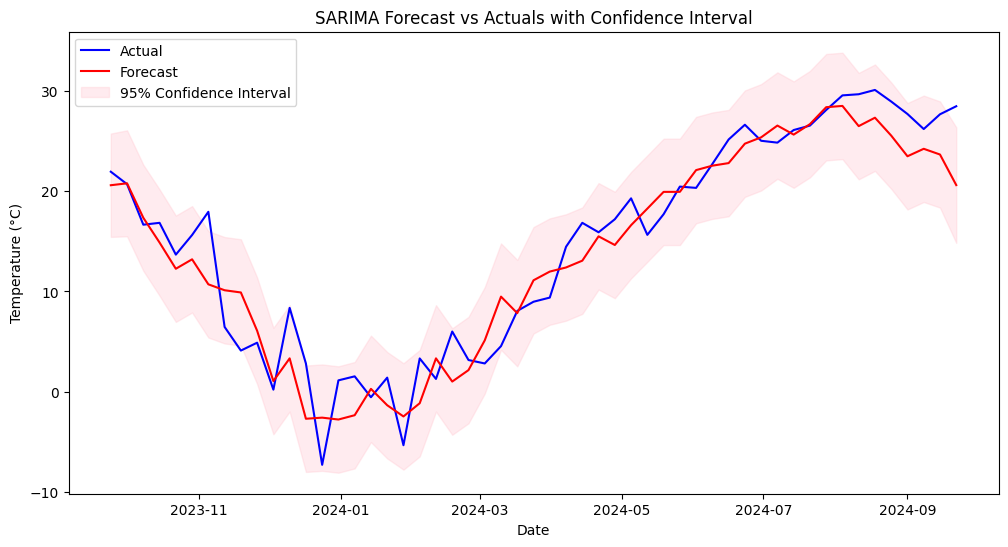

In [63]:
# 시각화
plt.figure(figsize=(12, 6))

# 실제 값
plt.plot(test_data.index, test_data, label='Actual', color='blue')

# 예측 값
plt.plot(test_data.index, forecast_values, label='Forecast', color='red')

# 신뢰 구간
plt.fill_between(test_data.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3, label='95% Confidence Interval')

plt.title('SARIMA Forecast vs Actuals with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

SARIMA 모델의 예측 결과는 계절적 패턴을 반영한 예측값을 보여줍니다. **실제 데이터(test_data)**와 **예측 데이터(forecast)**를 비교하여 계절성을 잘 반영했는지 확인할 수 있습니다. 또한 95% 신뢰 구간을 통해 예측값이 실제로 위치할 가능성이 높은 범위를 시각적으로 확인할 수 있습니다.

### 4.10. 결론

SARIMA 모델은 ARIMA 모델과 달리 계절적 패턴을 반영할 수 있으며, 기온과 같은 명확한 계절성을 띠는 데이터에 매우 적합합니다. SARIMA 모델을 통해 ARIMA 모델의 한계를 극복하고, 보다 정확한 예측을 수행할 수 있었습니다.

잔차 분석과 예측 성능 평가를 통해 SARIMA 모델이 실제 데이터와 어떻게 일치하는지 확인할 수 있으며, 특히 기온 데이터와 같은 자연 데이터에서는 SARIMA 모델이 더 적합한 것을 확인할 수 있었습니다.


---
#5. 강의 마무리

> 이번 실습에서는 일별 및 주별 평균기온 데이터를 활용해 ARIMA와 SARIMA 모델링을 진행했습니다. 이를 위해 정상성 검정, ACF/PACF 분석을 통해 차수를 결정하고 잔차를 검정하는 과정을 함께 살펴보았습니다.
> 다음 4회차 실습에서는 이번 실습에서 사용한 데이터(서울 일별/주별 평균기온데이터)를 바탕으로 Auto-ARIMA와 Prophet을 활용한 시계열 모델링 기법에 대해 알아봅시다.


